## Main Challenge

For this challenge, you are given various stocks and then are also given an ETF. However, when you open up the data, you will notice that the data is a little messy. Your first job is to clean the data before you work with it. Your goal for this problem is to find all potential mispricings in the ETF and areas where you can capture a profitable position. After you have finished, you are required to summarize your thought process behind your code. Your goal is not to calculate the profit and loss of your trades, but track the places where you see a opportunity to profit. (This could be having a short or long position). A completed project would consist of the following:
- Graph of ETF with blue and red arrows indicating where you would ideally enter a position or close a position.
- Summary describing what specific types of traders would be ideal in that situation and where you think the ETF was mispriced.

You will be graded on how well-written your code is, the strategies you come up with, and your overall documentation. The only packages that you are allowed to implement are pandas, numpy, and matplotlib. These packages are completely optional to use. AI is allowed as long as you document where you use it. Finally, documentation is required and typing is highly recommended.  Happy coding :)

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Clean Data

In [2]:
data = pd.read_csv('/Users/yuvananthony/Downloads/SSMIF Coding Challenge S25/General Coding Challenge S25/price_data.csv')

def clean_data(df):
    
    #start with dropping na values and duplicates
    df = df.dropna()
    df = df.drop_duplicates()
    
    #list of characters to remove from the dataset
    remove = ['a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
             'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] 

    for col in df.columns:
                
        for char in remove:
            
            df[col] = df[col].str.replace(char, '', regex = True) #treats alphabet as a regular expression, so it can remove any occurance of it instead of iterated through it
    
    df = df.astype(float)

    return df

#run the data through the function
data = clean_data(data)

#seperate the data by stocks and etf
stockA = data['Stock A']
stockB = data['Stock B']
stockC = data['Stock C']
stockD = data['Stock D']
etf = data['ETF']

## Strategy

In [3]:
#estimate weights of stocks in etf using fourier transform

def est_weights():
    #convert to numpy arrays to use numpy functions
    stocka_arr = stockA.values.flatten()
    stockb_arr = stockB.values.flatten()
    stockc_arr = stockC.values.flatten()
    stockd_arr = stockD.values.flatten()
    etf_arr = etf.values.flatten()
    
    #use the fft module and the fft function on each array to find the fast fourier transform of each stock
    #transforms time domain(stocka_arr) into frequency domain of sin and cosin waves
    #the sin part is the imaginary number, while the cosine part is the real number
    stocka_fft = np.fft.fft(stocka_arr)
    stockb_fft = np.fft.fft(stockb_arr)
    stockc_fft = np.fft.fft(stockc_arr)
    stockd_fft = np.fft.fft(stockd_arr)
    etf_fft = np.fft.fft(etf_arr)
    
    #Aw = b
    #A is the fourier transformed STOCK prices into a numpy matrix
    #taking only the cosin part, and the first 5 of them because they are the lowest frequency, captures overall movement
    A = np.vstack([
        np.real(stocka_fft[:5]),
        np.real(stockb_fft[:5]),
        np.real(stockc_fft[:5]),
        np.real(stockd_fft[:5])
    ]).T
        
    #b is the fourier transformed ETF prices
    b = np.real(etf_fft[:5])


    #instead of directly solving for the weights, use least squares to find the best estimation of the weights, since there is no exact answer
    #this finds the margin of error and uses it to make a good estimation of what the weights are
    w, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
    
    #make the weights sum up to 1
    weights = np.abs(w) / sum(np.abs(w))
    
    return weights

weights = est_weights()

#assign each weight by stock
stocka_weight = weights[0]
stockb_weight = weights[1]
stockc_weight = weights[2]
stockd_weight = weights[3]

In [4]:
#use the net asset value to find mispricings
nav = stockA * stocka_weight + stockB * stockb_weight + stockC * stockc_weight + stockD * stockd_weight

#find the error of the etf prices to find the mispricing
mispricing = ((etf - nav) / nav) * 100

#find the zscore of these mispricings to scale the mispricing by the etf
#z score tells you how many standard deviations a price is from its mean
#through this you can find when there are large price deviations
mispricing_zscore = (mispricing - mispricing.rolling(window = 21).mean()) / mispricing.rolling(window = 21).std()

#create an empty array of zeros for signals
signal = np.zeros(len(mispricing_zscore))

#if the mispricing is less than 2.5 standard deviations below the mean, buy
signal[mispricing_zscore < -2.5] = 1

#if the mispricing is greater than 2.5 standard deviations above the mean, sell
signal[mispricing_zscore > 2.5] = -1

#convert the signal to a pandas series
signal = pd.Series(signal, index=mispricing_zscore.index)

#join the etf and signals to have data in one dataframe
etf_signals = etf.to_frame(name='ETF Price').join(signal.to_frame(name='Signal'))

#fix error where column titles were in the data
etf_signals = etf_signals[1:]
etf_signals = etf_signals.rename(columns={etf_signals.columns[0]: "ETF Price", etf_signals.columns[1]: "Signal"})

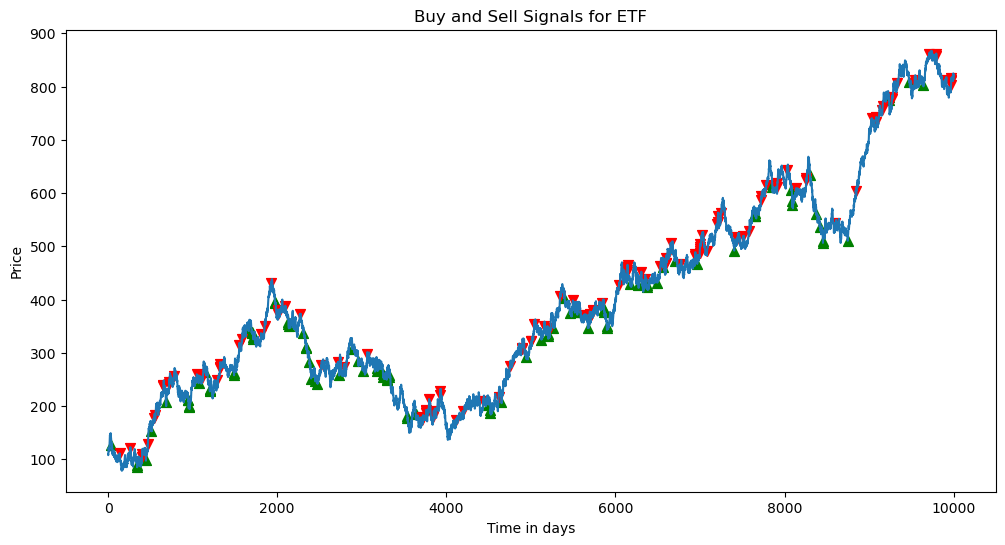

In [13]:
#make plot larger
plt.figure(figsize = (12, 6))
plt.title('Buy and Sell Signals for ETF')
plt.xlabel('Time in days')
plt.ylabel('Price')

#plot the etf prices
plt.plot(etf_signals['ETF Price'])

#create buy and sell signals to plot
buy = etf_signals[etf_signals['Signal'] == 1]
sell = etf_signals[etf_signals['Signal'] == -1]

#plot the buy signals with a green ^
plt.scatter(buy.index, buy['ETF Price'], marker = '^', color = 'green', s = 50)

#plot the sell signals with a red v
plt.scatter(sell.index, sell['ETF Price'], marker = 'v', color = 'red', s = 50)

#below the chart have a chart that shows total trades taken (long and short)
#short and long entries win percentage
#average profit on long and short entries
#average loss on long and short entries

## Summary

In [ ]:
'''
My strategy was to estimate what the ETF movement should be based on its individual 
stock movement and how the ETF's prices deviate from it. To do this, I first had to estimate
each stock's weight in the ETF. To do this I used a Fourier Transform strategy and then scaled
the data, so the weights summed to 1. Next, I found the net assed value based on the stock
prices and their weights. Then I used the error formula to find the deviation between the ETF
and the net asset value of the stocks. To scale and standardize the mispricings, I used
the z-score formula, and would generate signals when there are extreme deviations between the 
ETF and NAV. I used a rolling window of 21 days or 1 trading month. I used 2.5 standard 
deviations to generate signals. For example, I would generate a buy signal when the mispricing
is 2.5 standard deviations below the mean, and a sell signal when the mispricing is 2.5 standard
deviations above the mean. Using 2.5, instead of 2, allowed for more security when making 
trading decisions, however less signals were produced. I plotted the ETF Prices, and then scatter-
plotted the arrows to indicate when to buy and sell.
'''

## Bonus
Calculate the Profit and Loss of your strategy.